In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

In [3]:
device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [4]:
cls_conf = ffhq256_autoenc_cls()
cls_model = ClsModel(cls_conf)
state = torch.load(f'checkpoints/{cls_conf.name}/last.ckpt',
                    map_location='cpu')
print('latent step:', state['global_step'])
cls_model.load_state_dict(state['state_dict'], strict=False)
cls_model.to(device);

Global seed set to 0


loading pretrain ... 130M
step: 1563562
loading latent stats ...
latent step: 9375


In [5]:
img_dir = 'imgs_align'
for i,file in enumerate(os.listdir(img_dir)):
    print(f'{i}: {file}')

0: idPhoto.png
1: megane.png
2: sample01.png
3: sandy.png
4: women_default.png
5: yotaka_default.png
6: yotaka_smile.png


In [52]:
data = ImageDataset(img_dir, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch_from = torch.stack([
    data[5]['img'],
    data[6]['img']
])

data2 = ImageDataset(img_dir, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch_to = data2[4]['img'][None]

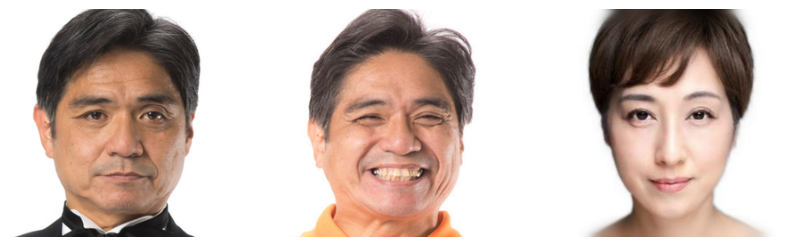

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(batch_from[0].permute([1, 2, 0]) / 2 + 0.5)
ax[1].imshow(batch_from[1].permute([1, 2, 0]) / 2 + 0.5)
ax[2].imshow(batch_to[0].permute([1, 2, 0]) / 2 + 0.5)
for i in range(3):
    ax[i].axis('off')
plt.show()

In [66]:
# 転写元
cond_from = model.encode(batch_from.to(device))
cond_change = cls_model.normalize(cond_from[1][None]) - cls_model.normalize(cond_from[0][None])
cond_change = cls_model.denormalize(cond_change)
cond_change_norm = F.normalize(cond_change, dim=1)

# 転写先
cond_to = model.encode(batch_to.to(device))
cond_to_norm = cls_model.normalize(cond_to)
xT = model.encode_stochastic(batch_to.to(device), cond_to, T=250)

In [72]:
print(np.linalg.norm(np.array(cond_change.cpu())))
print(np.linalg.norm(np.array(cond_change_norm.cpu())))

6.3517017
1.0


In [75]:
preds = []
alpha = torch.tensor(np.linspace(0, 6, 60, dtype=np.float32)).to(device)
for i, alp in enumerate(alpha):
    cond2 = cond_to_norm + alp * math.sqrt(512) * cond_change_norm
    cond2 = cls_model.denormalize(cond2)
    pred = model.render(xT, cond2, T=100)
    preds.append(pred[0])

KeyboardInterrupt: 

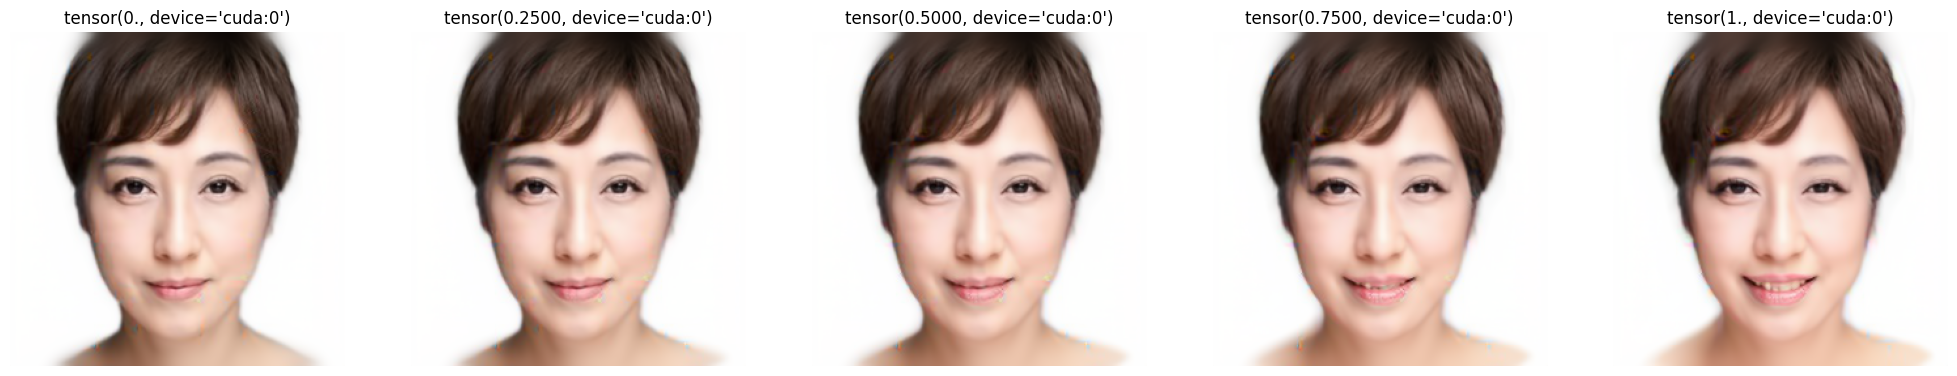

In [74]:
import matplotlib.pyplot as plt

num_show = 5
fig,ax = plt.subplots(1,num_show, figsize=(5*num_show, 5))
for i,j in enumerate(np.linspace(0,len(preds)-1,num_show,dtype=np.uint8)):
    ax[i].imshow(preds[j].permute(1,2,0).cpu())
    ax[i].set_title(alpha[j])
    ax[i].axis('off')

## gifの保存

In [81]:
from PIL import Image

preds_pil = []
for p in preds:
    p_np = np.array((p*255).permute(1,2,0).cpu()).astype(np.uint8)
    preds_pil.append(Image.fromarray(p_np))

In [82]:
dst_dir = "imgs_test/imgs_transfer/"
file_name = "yotaka2smile_trans_women.gif"
if not os.path.exists(dst_dir):
    os.mkdir(dst_dir)
dst_path = dst_dir + file_name

preds_pil[0].save(
    dst_path,
    format="gif",
    save_all=True,
    append_images=preds_pil,
    duration=33,
    loop=0,
)

## 静止画像の保存

In [41]:
from torchvision.utils import save_image

index = 59
dst_dir = "imgs_test/imgs_transfer/"
file_name = "yotaka2smile_trans_women%02d.png" % index
dst_path = dst_dir + file_name
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

save_image(preds[index], dst_path)